# PZ-model

## Model

(Using the same Fourier transform convention as in allpole.ipynb.)

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$ has the same form as an AP (all-pole) model:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

But now each coefficient $c_k$ is determined by 2 free parameters $(a_k,b_k) \in \mathbb{R}$:

$$ c_k = {a_k - ib_k \over 2} \iff (a_k = c_k + c_k^*, b_k = ic_k - ic_k^*)$$

such that

$$ c_k e^{p_k t} + c_k^* e^{p_k^* t} = (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) $$

The transfer function follows immediately from the form of the impulse response $h(t; p)$:

$$ \tilde{h}(x; p) = \sum_{k=1}^K {c_k \over 2\pi i x - p_k} + {c_k^* \over 2\pi i x - p_k^*} $$

[Note that the AP model can also be written in this way, but the expression for $c_k$ is more involved (the excluded pole product).]

In this form it is easy to see that the analytical spectral tilt at $x \rightarrow \infty$ should be about -6 dB/oct, independent of $K$, since $\tilde{h}(\infty, p) \propto 1/x$. Ofcourse the amplitudes can conspire in such ways that, e.g., the model collapses to an AP model with characteristic $(-12K)$ dB/oct tilt.

Collecting the terms, we get a proper transfer function in rational form:

$$ \tilde{h}(x; p) = {N(2\pi i x) \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

where $N(2\pi i x)$ is a polynomial of degree at most $2K - 1$.

## Normalization

If we adapt the same normalization as the AP, i.e., $\tilde{h}(0; p) := 1$, we would have to divide $\tilde{h}(x; p)$ **and $h(t; p)$** by the following factor:

$$DC = -2 \sum_{k=1}^K {Re(c_k p_k^*) \over |p_k|^2}$$

However, doing this would stop $h(t; p)$ from being purely linear in the amplitudes (since $DC$ depends on $c_k = {a_k - ib_k \over 2}$) and this is counterproductive; much better to normalize implicitly using the ME prior that yields a MVN over $(a,b)$ directly. Below we show that this yields superior normalization compared to AP -- it yields impulse responses $h(t; p)$ whose peak amplitudes are O(1), just what we like because our data peak amplitude is O(2) and our source DGF peak amplitude is O(5).

## Comparison with AP model

Disadvantages:
- Twice as much parameters: $(4K)$ (PZ) instead of $(2K)$ (AP)

Advantages:
- Automatically regularizes itself ("nested model")
- Can model more realistic spectral tilt
- Easier normalization such that the peak amplitudes of the impulse response $h$ are O(1) using our ME prior
- Can model zeros more easier
- Independent amplitudes of the formant peaks, which seems intuitively desirable

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

from vtr.prior import polezero

2022-11-29 16:53:57.381218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## The amplitude prior

[Based on: von der Linden (2014) Eq. (21.67) p. 348-349]

The impulse response is just a basis function expansion with $E=2K$ terms with amplitudes $a_k, b_k$:
$$ \begin{align}
h(t; p) &= (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t} \\
&= (t \geq 0) \times \sum_{k=1}^K (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) \\
&= \sum_{i=1}^{E=2K} \alpha_i \phi_i(t)
\end{align}$$
where $(\alpha_i = a_i \text{ if $i \leq K$ else } b_{i-K})$ and we tried to follow the notation of von der Linden.

So we can assign a prior to the amplitudes based on the energy (wrongly called $P(a)$ suggesting power -- but power needs to be divided by time) of the impulse response:
$$
\mathcal{E}(\alpha) = \int dt h(t; p)^2 = \sum_{ij=1}^E a_i a_j S_{ij} = \mu^2
$$
Here $S_{ij}$ is the overlap matrix which can be calculated analytically.
Similar calculations are done in @Bretthorst1991 in the discrete time domain, but our continous formulation (the $\int$ instead of $\sum$) allows for efficient close-form formulas. These are given in `vtr/overlapmatrix.nb`. Then the MVN prior for the amplitudes given the poles $p$ is
$$ p(a|p,\mu^2) = MVN(0, \Sigma) $$ where $$ \Sigma = {\mu^2 \over 2K} S(p)^{-1}$$.

Note that $S_{ij}$ and $\mu^2$ have dimensions of time. In our case we assign $\mu^2 = O(1) = 1\ msec$.
Why?
The normalized-to-unit-power speech data has typical peak amplitude O(2).
The source prior typically yields O(5) peak amplitude in DGF waveform.
Therefore we want our impulse response $h(t)$ to have O(1) peak amplitude.
This is well accomplished by setting $\mu^2 = 1\ msec$.

(This is an example of why it is good to work in a scale where things are O(1), so that O(1) guesses for parameter are likely to succeed without putting any though in it.)

In [2]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

[Memory]8.7s, 0.1min    : Loading get_vtrformants_training_data...


[Memory]10.0s, 0.2min   : Loading run_nested...
[Memory]12.9s, 0.2min   : Loading run_nested...


energy [msec] = (1.8824318989750646, 1.882357073015665)


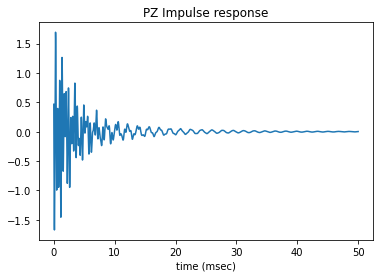

In [7]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)

h = polezero.impulse_response(t, x, y, ab)
plot(t, h)
title("PZ Impulse response")
xlabel("time (msec)")

# Calculate energy numerically and compare with analytical result
energy = np.dot(h, h)*dt
print("energy [msec] =", (energy, polezero.impulse_response_energy(x, y, ab)))

Test if the expected values $<\mu^2>$ is close to its prescribed value (1 msec):

1.0045469518426366

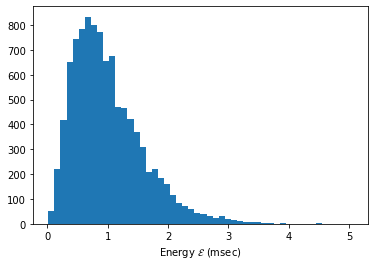

In [4]:
energies = []
for _ in range(10000):
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    energies += [polezero.impulse_response_energy(x, y, ab)]

hist(energies, bins=50)
xlabel("Energy $\mathcal{E}$ (msec)")
mean(energies) # msec

## Check power spectrum

-3.694740024882577

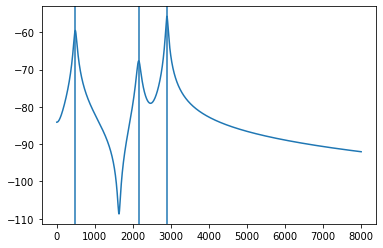

In [5]:
K = 3
x, y = samplexy()

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = polezero.transfer_function_power_dB(f, x, y, ab)
plot(f, power)
for xi in x: axvline(xi)
spectrum.fit_tilt(f, power)

### AP model as a special case of PZ

The PZ model includes the AP model as a special case, when the amplitudes $(a,b)$ take on specific values:

[-6.32755356e-02  8.15306158e-05  6.31940050e-02  6.08468384e+00
 -5.30595556e+00  2.09049606e+00]


-27.868268541744825

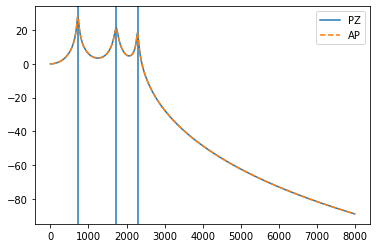

In [8]:
K = 3
x, y = samplexy(K)

# Calculate the amplitudes that turn the PZ into an AP
poles = core.make_poles(y, x)
c = core.pole_coefficients(poles)
a = real(c + conj(c))
b = real((1j)*(c - conj(c)))
ab_AP = np.concatenate((a, b))
print(ab_AP)

power = polezero.transfer_function_power_dB(f, x, y, ab_AP, normalize_gain=True)
plot(f, power, label="PZ")
for xi in x: axvline(xi)

plot(f, allpole.transfer_function_power_dB(f, x, y), '--', label="AP")
legend();

spectrum.fit_tilt(f, power)

But does the $p(a,b|p,\mu^2)$ prior place any mass at that specific point? **No.** We can check this in two ways:

1. Distribution of spectral tilt: tilt of 3-pole AP model is roughly -36 dB/oct, and this lies far away from the tilts of the PZ model

CPU times: user 1min 47s, sys: 4.99 ms, total: 1min 47s
Wall time: 1min 47s


-7.09329597955044

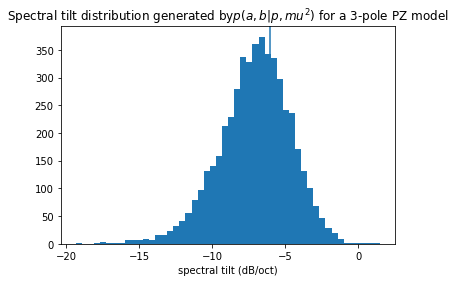

In [7]:
%%time
tilts = []

K = 3
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)

for i in range(5000):
    x, y = samplexy()
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    power = polezero.transfer_function_power_dB(f, x, y, ab)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    tilts += [spectrum.fit_tilt(f, power)]

hist(tilts, bins=50);
axvline(polezero.analytical_tilt())
title("Spectral tilt distribution generated by$ p(a,b|p,mu^2)$ for a 3-pole PZ model")
xlabel("spectral tilt (dB/oct)")
mean(tilts)

2. A direct check: where does the special point at which $(a,b) == $ `ab_AP` turn the PZ model into a "degenerate" AP model lie with respect to the distribution of the $(a,b)$ prior? Answer: far away. Blue points in the corner plot below: lie basically outside of the support of our ME prior for the $(a,b)$ amplitudes. And indeed, the typical peak amplitudes of the impulse response of the AP model are roughly 10x larger than those of the PZ model.

[-0.04317236  0.0512266  -0.00805424  2.59496492 -0.97413535  0.06252569]


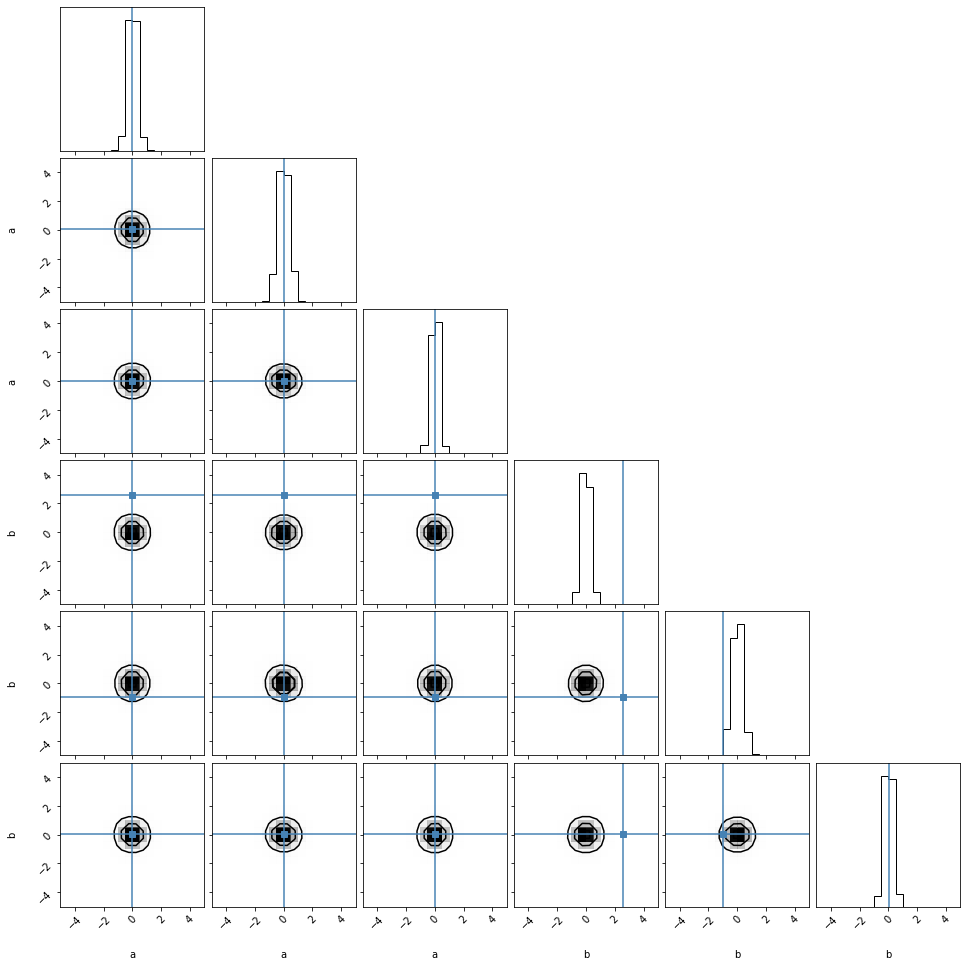

In [8]:
import corner
import itertools

print(ab_AP)

x, y = samplexy()
ab_samples = polezero.amplitudes_prior_ppf(rand(2*K, 1000), x, y).T

corner.corner(
    ab_samples,
    range = itertools.repeat((-5, 5), 2*K),
    labels = [*["a"]*K, *["b"]*K],
    smooth = 1.,
    truths = ab_AP
);

## Try a fit to a TFB sample

In [65]:
samples = bandwidth.get_TFB_samples()

________________________________________________________________________________
[Memory] Calling vtr.prior.bandwidth.get_TFB_samples...
get_TFB_samples()
[Memory]181653.8s, 3027.6min: Loading get_vtrformants_training_data...
[Memory]181654.2s, 3027.6min: Loading run_nested...
[Memory]181654.5s, 3027.6min: Loading run_nested...
__________________________________________________get_TFB_samples - 4.6s, 0.1min


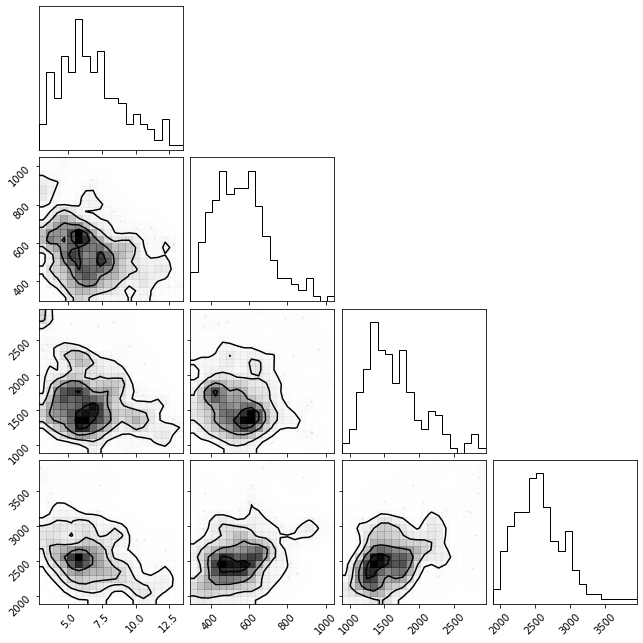

In [66]:
# Did we cover the (T, F^Ref) space sufficiently?
TF = np.vstack([np.array((s['T'], *s['F'])) for s in samples])
corner.corner(TF, smooth=1.);

In [10]:
fitted = polezero.get_fitted_TFB_samples()

[Memory]125.0s, 2.1min  : Loading get_TFB_samples...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.0s, 2.1min  : Loading run_nested...
[Memory]125.1s, 2.1min  : Loading run_nested...
[Memory]125.1s, 2.1min  : Loading run_nested...
[Memory]125.1s, 2.1min  : Loading r

In [23]:
K = 6
sample_index = 40

def getfit(K, sample_index):
    return fitted[(K-3)*50+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results = fit['results']

In [21]:
K = 10
sample = samples[11]

results = polezero.fit_TFB_sample(sample, K, 11111111000) # with energy

NameError: name 'samples' is not defined

In [ ]:
from lib import util
util.dyplot(results, (*["x"]*K, *["y"]*K, *["a"]*K, *["b"]*K))

In [ ]:
u = array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.03893541e-01,  9.02011544e-01,  6.52352763e-01,  1.49843031e-01,
        6.47924376e-02,  1.38291999e-01,  3.51307847e-01,  1.36200380e+00,
        2.23355140e+00,  3.44520280e+00,  4.16893955e+00,  5.28352365e+00,
        5.81458725e+00,  5.63384624e+00,  5.26359729e+00,  4.61548500e+00,
        3.78567022e+00,  2.12612670e+00,  5.90308744e-01, -1.96413967e-01,
       -9.42429102e-01, -1.94479140e+00, -2.94237693e+00, -3.92009285e+00,
       -4.83803198e+00, -4.38043435e+00, -3.56124232e+00, -2.13100145e+00,
       -1.80829929e+00, -2.01075844e+00, -1.85180180e+00, -1.65290012e+00,
       -1.58986415e+00, -1.75945799e+00, -2.37785324e+00, -2.84134913e+00,
       -2.29888179e+00, -1.60987394e+00, -1.09956638e+00, -3.95130189e-01,
        1.25425359e-02, -5.75650346e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.59842551e-02,  9.25175619e-01,  4.20383649e-01, -3.81763454e-01,
       -6.43227438e-01, -5.87809324e-01, -4.54590904e-01,  7.23953948e-01,
        1.84527770e+00,  3.39040905e+00,  4.20820755e+00,  5.67325995e+00,
        6.39309137e+00,  6.35165031e+00,  6.07687971e+00,  5.60988035e+00,
        4.92983945e+00,  3.01983109e+00,  1.07886251e+00,  8.15762513e-03,
       -9.59207468e-01, -2.09267582e+00, -3.17899206e+00, -4.45168141e+00,
       -5.83257522e+00, -5.85190636e+00, -4.84758179e+00, -2.84775911e+00,
       -1.82399281e+00, -1.96382329e+00, -1.94260711e+00, -1.36470141e+00,
       -1.29729289e+00, -9.90017940e-01, -1.63014518e+00, -2.50608358e+00,
       -2.62164135e+00, -1.71984051e+00, -1.00576080e+00, -3.82112907e-01,
        5.52862325e-01,  5.16019338e-01, -6.10323288e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.83039348e-01,  7.35389279e-01,
        5.88786020e-01, -1.69692665e-01, -3.96701941e-01, -4.23470495e-01,
       -3.38592935e-01,  4.99722633e-01,  1.63948490e+00,  2.75390156e+00,
        3.57791958e+00,  4.91880014e+00,  5.44431292e+00,  5.68433444e+00,
        5.47869231e+00,  5.03548763e+00,  4.33833838e+00,  2.92200654e+00,
        1.17454999e+00, -3.41368703e-02, -7.85488633e-01, -1.50220132e+00,
       -2.51134193e+00, -3.73705191e+00, -4.88250656e+00, -5.47636216e+00,
       -4.63799056e+00, -3.30124267e+00, -1.87342735e+00, -1.71438496e+00,
       -1.89300585e+00, -1.45343666e+00, -1.14502032e+00, -8.60070119e-01,
       -1.08780235e+00, -1.84647032e+00, -2.57878980e+00, -1.92026010e+00,
       -1.16406300e+00, -5.71190386e-01,  3.31159278e-01,  9.85187281e-01,
        4.15378261e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.50074233e-01,  5.85980289e-01,  7.16886122e-01, -8.42683595e-02,
       -4.12864097e-01, -4.60398589e-01, -3.44857958e-01,  7.79993213e-01,
        1.89134933e+00,  3.21520048e+00,  3.98795656e+00,  5.01302555e+00,
        5.52324819e+00,  5.35663494e+00,  5.06819302e+00,  4.48473044e+00,
        3.34954065e+00,  1.41983452e+00,  2.85525508e-02, -7.53711527e-01,
       -1.59147328e+00, -2.65240209e+00, -3.95448582e+00, -5.27510412e+00,
       -5.33666041e+00, -4.41679924e+00, -2.53321932e+00, -1.97462779e+00,
       -2.12644734e+00, -1.63274036e+00, -1.06142269e+00, -7.36930605e-01,
       -8.24384948e-01, -1.57060904e+00, -2.10222156e+00, -1.29963203e+00,
       -7.45631139e-01, -1.22970664e-01,  6.16872072e-01,  3.14968261e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.16827838e-03,  8.68965802e-01,  4.11804043e-01, -2.01602079e-01,
       -3.83076187e-01, -5.20000956e-01, -4.09787953e-01,  7.33465554e-01,
        1.85927442e+00,  3.33270997e+00,  4.16564447e+00,  5.41834794e+00,
        5.93909783e+00,  5.92537208e+00,  5.69308223e+00,  5.23087154e+00,
        4.42726046e+00,  2.42864270e+00,  4.52629381e-01, -6.68220639e-01,
       -1.52988004e+00, -2.45582620e+00, -3.37638094e+00, -4.57665242e+00,
       -5.65282137e+00, -5.57334521e+00, -4.66336132e+00, -2.84962302e+00,
       -2.02697914e+00, -2.15701685e+00, -1.87524955e+00, -1.00138014e+00,
       -7.31305376e-01, -3.00148192e-01, -7.80798729e-01, -1.62072469e+00,
       -1.84443833e+00, -1.17123322e+00, -6.63869939e-01, -1.75545563e-01,
        4.87842277e-01,  2.01868764e-01, -9.51874414e-01])

In [20]:
from vtr.prior.polezero import *

def unpack(params):
    xy, ab = np.split(params, 2)
    x, y = np.split(xy, 2)
    return x, y, ab

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F=constants.SIGMA_FB_REFERENCE_HZ,
    sigma_B=constants.SIGMA_FB_REFERENCE_HZ,
    tilt_target=constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt=constants.SIGMA_TILT_DB,
    energy_target=constants.IMPULSE_RESPONSE_ENERGY_MSEC,
    sigma_energy=constants.SIGMA_IMPULSE_RESPONSE_ENERGY_MSEC
):
    x, y, ab = unpack(params)
    
    # Calculate pole-zero transfer function
    power = transfer_function_power_dB(f, x, y, ab)

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    tilt = spectrum.fit_tilt(f, power, cutoff=F_true[-1])
    
    # Calculate impulse response energy (in msec)
    energy = impulse_response_energy(x, y, ab)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2
    energy_err = ((energy - energy_target)/sigma_energy)**2
    
    # Print debug information
    print(np.round(F, 2), np.round(F_true, 2))
    print(np.round(B, 2), np.round(B_true, 2))
    print(F_err, B_err, tilt_err, energy_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = transfer_function_power_dB(f, x, y, ab)
    plot(f, power, "grey")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    xlim(None, 5000);
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = polezero.impulse_response(t, x, y, ab)
    plot(t, h)
    d = convolve(h, u)*dt
    plot(d)
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_KHZ, scale='dB')
    show()
    
    return -(F_err + B_err + tilt_err + energy_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())

TypeError: 'builtin_function_or_method' object is not subscriptable

mu2(analytical) [msec] = 9.770675210040919
mu2 [msec] = 9.771058789318477


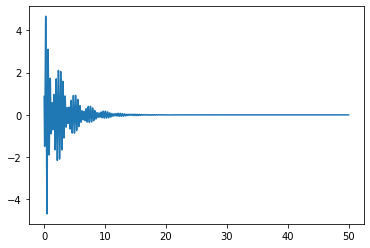

9.763664828329706

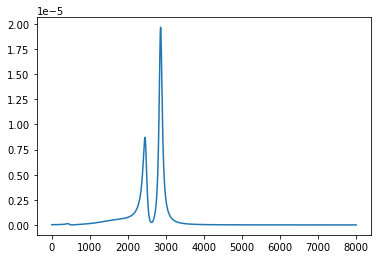

In [26]:
x, y, ab = unpack(util.resample_equal(results, 1).squeeze())

##

S = polezero.overlap_matrix(x, y)
mu2_analytical_sec = ab.T @ S @ ab
print("mu2(analytical) [msec] =", mu2_analytical_sec*1000)

##

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec
G = eval_G(t, x/1000, y/1000)

h = G @ ab
plot(t, h)

mu2 = np.dot(h, h)*dt
print("mu2 [msec] =", mu2)

##

f = sample['f']

power_db = polezero.transfer_function_power_dB(f, x, y, ab)
power = 10**(power_db/10)

show()
plot(f, power)

scipy.integrate.trapezoid(power, f)/1000*2*10**6 # sec/msec problem